In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/cats vs dogs.zip'

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil

In [ ]:
# Directory that holds the data
DATA_DIR = '/content/PetImages'

# Subdirectories for each class
data_dir_cat = os.path.join(DATA_DIR, 'Cat')
data_dir_dog = os.path.join(DATA_DIR, 'Dog')

# os.listdir returns a list containing all files under the given dir
print(f'There are {len(os.listdir(data_dir_cat))} Cat images in cats directory')
print(f'There are {len(os.listdir(data_dir_dog))} Dog images in Dogs directory')

There are 12499 Cat images in cats directory
There are 12499 Dog images in Dogs directory


In [ ]:
# clean bad images with invalid channels from the dataset
bad_count = 0
DATA_DIR = '/content/PetImages'

for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    print(f'checking images inside {folder_path}')

    for file_name in os.listdir(folder_path):
      file_path = os.path.join(folder_path, file_name)

      try:
        img_read = tf.io.read_file(file_path)
        img = tf.io.decode_image(img_read, channels=3)
        if img.shape[-1] != 3:
          bad_count += 1
          print(f'Removin {file_name} with bad channels {img.shape[-1]}')
          os.remove(file_path)

      except Exception as e:
        print(f'Error processing {file_path} with Exception {e}')
        bad_count += 1
        os.remove(file_path)


cat_dir = os.path.join(DATA_DIR, 'Cat')
dog_dir = os.path.join(DATA_DIR, 'Dog')

print(f'Removed {bad_count} bad images from the dataset with bad channels')
print(f'There are {len(os.listdir(cat_dir))} Cat images in cats directory')
print(f'There are {len(os.listdir(dog_dir))} Dog images in Dogs directory')


checking images inside /content/PetImages/Dog
Error processing /content/PetImages/Dog/11233.jpg with Exception {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Error processing /content/PetImages/Dog/9500.jpg with Exception {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Error processing /content/PetImages/Dog/2317.jpg with Exception {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Error processing /content/PetImages/Dog/11912.jpg with Exception {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 

In [ ]:
cats_files_name = [os.path.join(data_dir_cat, fname) for fname in os.listdir(data_dir_cat)]
dogs_files_name = [os.path.join(data_dir_dog, fname) for fname in os.listdir(data_dir_dog)]


print(f'the first 5 images of cats with name are : {cats_files_name[:5]}')
print(f'the first 5 images of dogs with name are : {dogs_files_name[:5]}')

the first 5 images of cats with name are : ['/content/PetImages/Cat/744.jpg', '/content/PetImages/Cat/3293.jpg', '/content/PetImages/Cat/4708.jpg', '/content/PetImages/Cat/7472.jpg', '/content/PetImages/Cat/5294.jpg']
the first 5 images of dogs with name are : ['/content/PetImages/Dog/744.jpg', '/content/PetImages/Dog/3293.jpg', '/content/PetImages/Dog/4708.jpg', '/content/PetImages/Dog/7472.jpg', '/content/PetImages/Dog/5294.jpg']


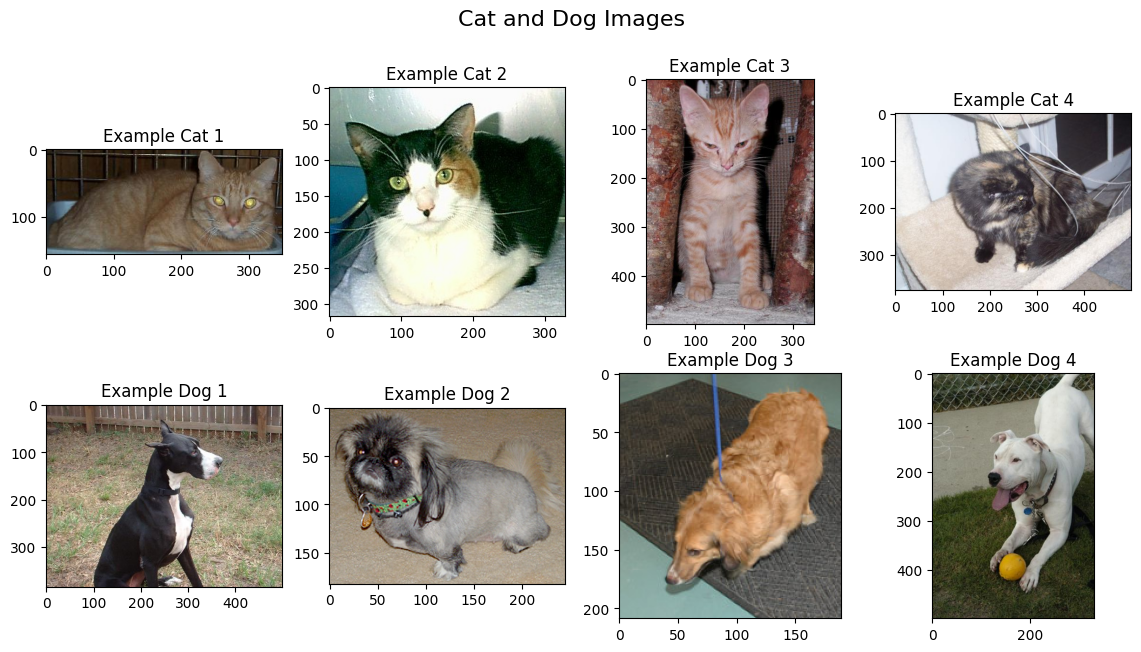

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cat and Dog Images', fontsize=16)

# Plot the first 4 images of each class
for i, cat_image in enumerate(cats_files_name[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cat {i+1}')

for i, dog_image in enumerate(dogs_files_name[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dog {i+1}')

plt.show()

In [ ]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    ### START CODE HERE ###

    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='/content/PetImages',
        image_size=(120, 120),
        batch_size=128,
        labels='inferred',
        label_mode='binary',
        subset='training',
        validation_split=0.15,
        seed=42
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='/content/PetImages',
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        labels='inferred',
        subset='validation',
        validation_split=0.15,
        seed=42
    )

    ### END CODE HERE ###

    return training_dataset, validation_dataset

In [ ]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 24991 files belonging to 2 classes.
Using 21243 files for training.
Found 24991 files belonging to 2 classes.
Using 3748 files for validation.


In [ ]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 120, 120, 3)
Shape of batch of labels: (128, 1)


In [ ]:
# GRADED FUNCTION: create_augmentation_model
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of cats and dogs.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of cats and dogs.
    """

    ### START CODE HERE ###

    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode = 'nearest'),
        tf.keras.layers.RandomContrast(0.2),
    ])

    ### END CODE HERE ###

    return augmentation_model

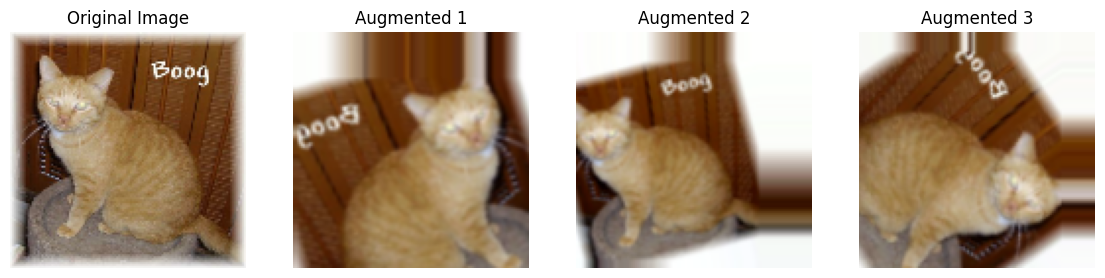

In [ ]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [ ]:
# GRADED FUNCTION: create_model

def create_model():
    """Creates the untrained model for classifying cats and dogs.

    Returns:
        tf.keras.Model: The model that will be trained to classify cats and dogs.
    """

    ### START CODE HERE ###

        # Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model() # Call the function to get the model

        # Don't forget to add the augmentation layers! These usually go right after the Input!
    model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(120, 120, 3)),
            tf.keras.layers.Rescaling(1./255),
            augmentation_layers, # Add the returned model (which is a Layer)
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    ### END CODE HERE ###

    return model

In [ ]:
# Create the compiled but untrained model
model = create_model()


In [ ]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 1)


In [ ]:
# GRADED CLASS: EarlyStoppingCallback

### START CODE HERE ###

# Remember to inherit from the correct class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None): # Changed epochs to epoch for consistency with Keras Callback API
        # Check if the accuracy is greater or equal to 0.95 and validation accuracy is greater or equal to 0.8
        if logs.get('accuracy') >= 0.80 and logs.get('val_accuracy') >= 0.80:
            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")
            self.model.stop_training = True






callbacks = EarlyStoppingCallback()
### END CODE HERE ###

In [ ]:
# Train the model and save the training history
# This may take up to 10-15 min so feel free to take a break! :P
history = model.fit(
	training_dataset,
	epochs=35,
	validation_data=validation_dataset,
	callbacks=[callbacks]
)

Epoch 1/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.5144 - loss: 0.7269 - val_accuracy: 0.6078 - val_loss: 0.6587
Epoch 2/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.6051 - loss: 0.6688 - val_accuracy: 0.6203 - val_loss: 0.6573
Epoch 3/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.6453 - loss: 0.6283 - val_accuracy: 0.7062 - val_loss: 0.5669
Epoch 4/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.6640 - loss: 0.6068 - val_accuracy: 0.7188 - val_loss: 0.5558
Epoch 5/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.6881 - loss: 0.5823 - val_accuracy: 0.7343 - val_loss: 0.5305
Epoch 6/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.6952 - loss: 0.5727 - val_accuracy: 0.7142 - val_loss: 0.5580
Epoch 7/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.7008 - loss: 0.5685 - val_accuracy: 0.7265 - val_loss: 0.5512
Epoch 8/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7063 - loss: 0

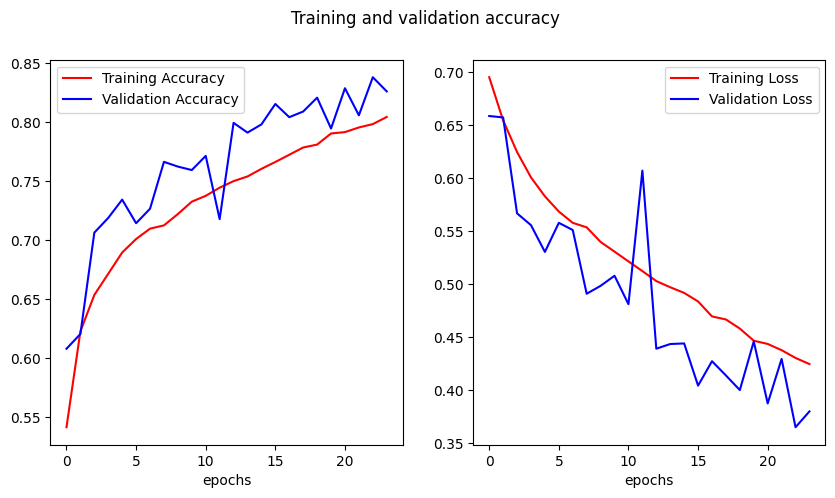

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()